<a href="https://colab.research.google.com/github/Miksan31/Agentic-AI/blob/main/Langgraph_usecase_InventoryStore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langgraph langchain langchainhub scikit-learn pandas numpy matplotlib seaborn pydantic --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.1 MB/s eta 0:00:00


Available columns: ['date', 'store_id', 'product_id', 'category', 'region', 'inventory_level', 'units_sold', 'units_ordered', 'demand_forecast', 'price', 'discount', 'weather_condition', 'holiday_promotion', 'competitor_pricing', 'seasonality']


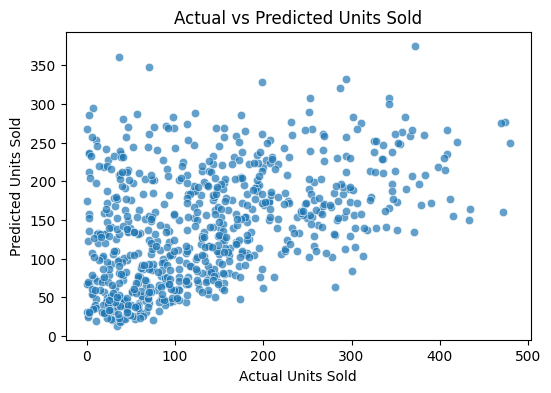

Evaluation Metrics:
MSE: 9356.68
R2 Score: 0.1482
{'MSE': 9356.6779891625, 'R2 Score': 0.14822795885417184}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langgraph.graph import StateGraph
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from typing import Annotated, Dict

StateType = Annotated[Dict[str, any], "State"]

# SQL Agent: Extract Data with Filtering and Selection
def sql_agent(input: StateType) -> StateType:
    df = input["data"].copy()

    # Standardizing column names: strip, lowercase, replace spaces and "/" with underscores
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("/", "_")

    print("Available columns:", df.columns.tolist())

    if "start_date" in input and "end_date" in input:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df = df.dropna(subset=["date"])
        df = df[(df["date"] >= input["start_date"]) & (df["date"] <= input["end_date"])]

    if "region" in input:
        df = df[df["region"].str.lower() == input["region"].lower()]

    if "category" in input:
        df = df[df["category"].str.lower() == input["category"].lower()]

    if "columns" in input:
        available_columns = df.columns.tolist()
        # Transform requested columns similarly
        input["columns"] = [col.lower().replace(" ", "_").replace("/", "_") for col in input["columns"]]
        missing_cols = [col for col in input["columns"] if col not in available_columns]

        if missing_cols:
            print(f"Warning: Missing columns {missing_cols}. Available columns: {available_columns}")
            input["columns"] = [col for col in input["columns"] if col in available_columns]

        df = df[input["columns"]]

    if "order_by" in input:
        order_by = input["order_by"].lower().replace(" ", "_").replace("/", "_")
        if order_by in df.columns:
            df = df.sort_values(by=order_by, ascending=True)

    if df.empty:
        print("Warning: No data after filtering. Adjust your filtering criteria.")
        return {"data": input["data"].head(5)}  # Return first 5 rows as fallback

    return {"data": df}

# Data Analysis Agent: Preprocessing and Insights
def data_analysis_agent(input: StateType) -> StateType:
    df = input["data"].copy()

    # Standardizing column names
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("/", "_")

    df = df.dropna()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    df = df.sort_values("date")

    df["month"] = df["date"].dt.month
    df["year"] = df["date"].dt.year
    df["day"] = df["date"].dt.day

    # Fill missing values in numeric columns robustly
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    df["weather_condition"] = df["weather_condition"].fillna("Normal")
    df["holiday_promotion"] = df["holiday_promotion"].fillna(0)

    return {"processed_data": df}

# Forecasting Agent: Predict Future Values
def forecasting_agent(input: StateType) -> StateType:
    df = input["processed_data"]

    if df.empty:
        return {"error": "Insufficient data for model training."}

    X = df[['month', 'year', 'day', 'inventory_level', 'holiday_promotion']]
    y = df['units_sold']

    if X.shape[0] < 2:
        return {"error": "Not enough samples to split into train and test sets."}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    return {"model": model, "X_test": X_test, "y_test": y_test, "predictions": predictions}

# Evaluation Agent: Assess Forecasting Performance
def evaluation_agent(input: StateType) -> StateType:
    if "error" in input:
        return {"evaluation": input["error"]}

    y_test, predictions = input["y_test"], input["predictions"]

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=predictions, alpha=0.7)
    plt.xlabel("Actual Units Sold")
    plt.ylabel("Predicted Units Sold")
    plt.title("Actual vs Predicted Units Sold")
    plt.show()

    print("Evaluation Metrics:")
    print(f"MSE: {mse:.2f}")
    print(f"R2 Score: {r2:.4f}")

    return {"MSE": mse, "R2 Score": r2}


# Build Workflow using LangGraph StateGraph
workflow = StateGraph(StateType)
workflow.add_node("sql_agent", sql_agent)
workflow.add_node("data_analysis_agent", data_analysis_agent)
workflow.add_node("forecasting_agent", forecasting_agent)
workflow.add_node("evaluation_agent", evaluation_agent)

workflow.add_edge("sql_agent", "data_analysis_agent")
workflow.add_edge("data_analysis_agent", "forecasting_agent")
workflow.add_edge("forecasting_agent", "evaluation_agent")

workflow.set_entry_point("sql_agent")
workflow.set_finish_point("evaluation_agent")

app = workflow.compile()

df = pd.read_csv("retail_store_inventory.csv")
# Standardize columns immediately after reading
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace("/", "_")
print(app.invoke({
    "data": df,
    "start_date": "2022-01-01",
    "end_date": "2024-12-31",
    "region": "East",
    "category": "Toys",
    "columns": ["date", "units_sold", "inventory_level", "weather_condition", "holiday_promotion"],
    "order_by": "date"
}))
